## 1. American Sign Language (ASL)
<p>American Sign Language (ASL) is the primary language used by many deaf individuals in North America, and it is also used by hard-of-hearing and hearing individuals.  The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/asl.png" alt="american sign language"></p>
<p>A lot of recent progress has been made towards developing computer vision systems that translate sign language to spoken language.  This technology  often relies on complex neural network architectures that can detect subtle patterns in streaming video.  However, as a first step, towards understanding how to build a translation system, we can reduce the size of the problem by translating individual letters, instead of sentences.</p>
<p><strong>In this notebook</strong>, we will train a convolutional neural network to classify images of American Sign Language (ASL) letters.  After loading, examining, and preprocessing the data, we will train the network and test its performance.</p>
<p>In the code cell below, we load the training and test data. </p>
<ul>
<li><code>x_train</code> and <code>x_test</code> are arrays of image data with shape <code>(num_samples, 3, 50, 50)</code>, corresponding to the training and test datasets, respectively.</li>
<li><code>y_train</code> and <code>y_test</code> are arrays of category labels with shape <code>(num_samples,)</code>, corresponding to the training and test datasets, respectively.</li>
</ul>

In [43]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5) 
import tensorflow as tf
tf.set_random_seed(2)
from datasets import sign_language
import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-shuffled training and test datasets
(x_train, y_train), (x_test, y_test) = sign_language.load_data()

In [44]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code.
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_1_0():
    assert 'np' in globals() and np.random.get_state()[1][0] == 5 and \
    x_train.shape==(1600, 50, 50, 3) and y_train.shape==(1600,), \
    'Please run the code cell without making any changes.'

1/1 tests passed


## 2. Visualize the training data
<p>Now we'll begin by creating a list of string-valued labels containing the letters that appear in the dataset.  Then, we visualize the first several images in the training data, along with their corresponding labels.</p>

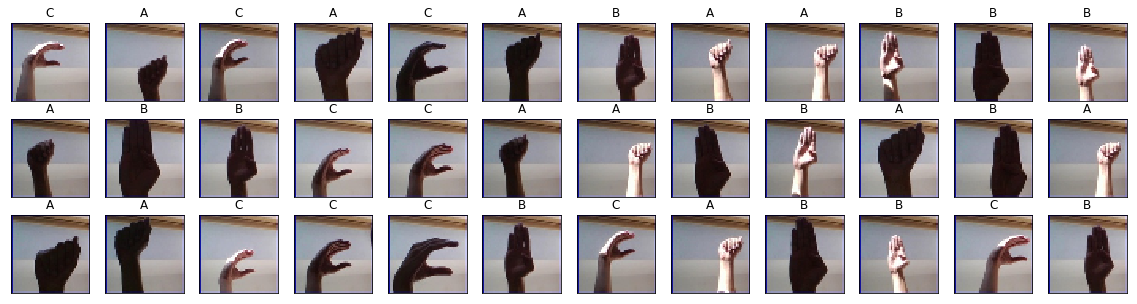

In [45]:
# Store labels of dataset
labels = ['A', 'B', 'C']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

In [46]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_2_0():
    assert labels == ['A', 'B', 'C'], \
    'Did you forget to set labels to a Python list with items "A", "B", and "C"?'

1/1 tests passed


## 3. Examine the dataset
<p>Let's examine how many images of each letter can be found in the dataset.</p>
<p>Remember that dataset has already been split into training and test sets for you, where <code>x_train</code> and <code>x_test</code> contain the images, and <code>y_train</code> and <code>y_test</code> contain their corresponding labels.</p>
<p>Each entry in <code>y_train</code> and <code>y_test</code> is one of <code>0</code>, <code>1</code>, or <code>2</code>, corresponding to the letters <code>'A'</code>, <code>'B'</code>, and <code>'C'</code>, respectively.</p>
<p>We will use the arrays <code>y_train</code> and <code>y_test</code> to verify that both the training and test sets each have roughly equal proportions of each letter.</p>

In [47]:
# Number of A's in the training dataset
num_A_train = sum(y_train == 0)
# Number of B's in the training dataset
num_B_train = sum(y_train == 1)
# Number of C's in the training dataset
num_C_train = sum(y_train == 2)

# Number of A's in the test dataset
num_A_test = sum(y_test == 0)
# Number of B's in the test dataset
num_B_test = sum(y_test == 1)
# Number of C's in the test dataset
num_C_test = sum(y_test == 2)

# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}".format(num_A_train, num_B_train, num_C_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}".format(num_A_test, num_B_test, num_C_test))

Training set:
	A: 540, B: 528, C: 532
Test set:
	A: 118, B: 144, C: 138


In [48]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_3_0():
    assert num_A_train == 540 and num_A_test == 118, \
    'Did you leave the values of num_A_train and num_A_test as provided?'
    
def test_task_3_1():
    assert num_B_train == 528, \
    'Did you set the value of num_B_train?'
    
def test_task_3_2():
    assert num_C_train == 532, \
    'Did you set the value of num_C_train?'
    
def test_task_3_3():
    assert num_B_test == 144, \
    'Did you set the value of num_B_test?'
    
def test_task_3_4():
    assert num_C_test == 138, \
    'Did you set the value of num_C_test?'

5/5 tests passed


## 4. One-hot encode the data
<p>Currently, our labels for each of the letters are encoded as categorical integers, where <code>'A'</code>, <code>'B'</code> and <code>'C'</code> are encoded as <code>0</code>, <code>1</code>, and <code>2</code>, respectively.  However, recall that Keras models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a Keras model.</p>
<p>This conversion will turn the one-dimensional array of labels into a two-dimensional array.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/onehot.png" alt="one-hot encoding"></p>
<p>Each row in the two-dimensional array of one-hot encoded labels corresponds to a different image.  The row has a <code>1</code> in the column that corresponds to the correct label, and <code>0</code> elsewhere.  </p>
<p>For instance, </p>
<ul>
<li><code>0</code> is encoded as <code>[1, 0, 0]</code>, </li>
<li><code>1</code> is encoded as <code>[0, 1, 0]</code>, and </li>
<li><code>2</code> is encoded as <code>[0, 0, 1]</code>.</li>
</ul>

In [49]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train, 3)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test, 3)

In [50]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_4_0():
    assert np.all(y_train_OH == np_utils.to_categorical(y_train, 3)), \
    'Did you use `np_utils.to_categorical` to obtain the one-hot training labels?'
    
def test_task_4_1():
    assert np.all(y_test_OH == np_utils.to_categorical(y_test, 3)), \
    'Did you use `np_utils.to_categorical` to obtain the one-hot test labels?'

2/2 tests passed


## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [51]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 50, 50, 5)         380       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 15)        1890      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 15)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 135)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 408       
Total params: 2,678
Trainable params: 2,678
Non-trainable params: 0
_________________________________________________________________


In [52]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_5_0():
    from keras.activations import relu
    assert model.layers[0].filters == 5 and \
    model.layers[0].kernel_size == (5, 5) and \
    model.layers[0].padding == 'same' and \
    model.layers[2].activation == relu, \
    'Did you leave the first convolutional layer as provided in the code?'

def test_task_5_1():
    assert model.layers[1].pool_size == (4, 4), \
    'Does the first pooling layer pool over windows of size 4x4?'
    
def test_task_5_2():
    assert model.layers[2].filters == 15, \
    'Does the second convolutional layer have 15 filters?'
    
def test_task_5_3():
    assert model.layers[2].kernel_size == (5, 5), \
    'Does the second convolutional layer have kernel size 5?'
    
def test_task_5_4():
    assert model.layers[2].padding == 'same', \
    'Does the second convolutional layer have "same" padding?'
    
def test_task_5_5():
    from keras.activations import relu
    assert model.layers[2].activation == relu, \
    'Does the second convolutional layer have a "relu" activation function?'
    
def test_task_5_6():
    assert model.layers[3].pool_size == (4, 4), \
    'Does the second pooling layer pool over windows of size 4x4?'

7/7 tests passed


## 6. Compile the model
<p>After we have defined a neural network in Keras, the next step is to compile it! </p>

In [53]:
# Compile the model
model.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [54]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_6_0():
    from keras.optimizers import RMSprop
    assert isinstance(model.optimizer, RMSprop), \
    'Did you set the optimizer to `"rmsprop"`?'

def test_task_6_1():
    assert model.loss == 'categorical_crossentropy', \
    'Did you set `"categorical_crossentropy" as the loss function?`'

def test_task_6_2():
    assert model.metrics == ['accuracy'], \
    'Did you set accuracy as the only metric that is evaluated by the model during training?'

3/3 tests passed


## 7. Train the model
<p>Once we have compiled the model, we're ready to fit it to the training data.</p>

In [55]:
# Train the model
hist = model.fit(x_train, y_train_OH,
                 validation_split=0.2,
                 epochs=2, 
                 batch_size=32)

Train on 1280 samples, validate on 320 samples
Epoch 1/2
1280/1280 [==============================] - 5s 4ms/step - loss: 0.9696 - acc: 0.5953 - val_loss: 0.7974 - val_acc: 0.7625
Epoch 2/2
1280/1280 [==============================] - 4s 3ms/step - loss: 0.6404 - acc: 0.8305 - val_loss: 0.4979 - val_acc: 0.9062


In [56]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_7_0():
    assert hist.epoch == [0,1], \
    'Did you train the model for 2 epochs?'

def test_task_7_1():
    assert hist.history['acc'][1] > 0.8, \
    'Did you use x_train and y_train_OH to train the model with a batch size of 32, and setting aside 20% of the data for validation?'

2/2 tests passed


## 8. Test the model
<p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
<p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

In [57]:
# Obtain accuracy on test set
score = model.evaluate(x = x_test, 
                       y = y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9275


In [58]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_8_0():
    assert score == model.evaluate(x=x_test, y=y_test_OH, verbose=0), \
    'Did you use the data in x_test and the one-hot labels in y_test_OH to evaluate the test accuracy?'

1/1 tests passed


## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

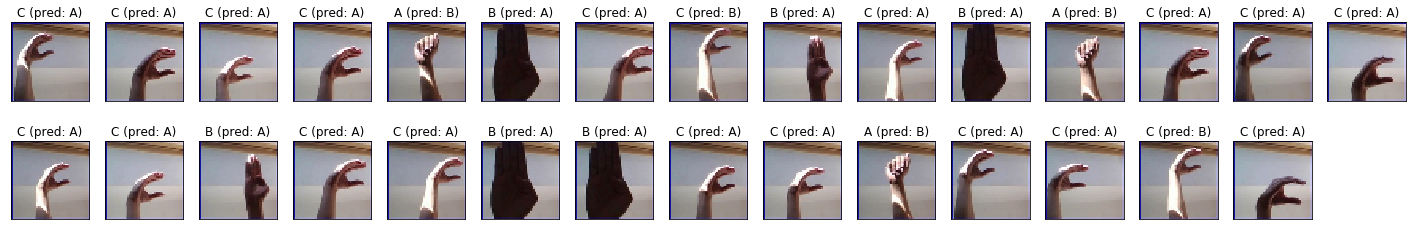

In [59]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

# Print mislabeled examples
fig = plt.figure(figsize=(25,4))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, np.ceil(len(bad_test_idxs)/2), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

In [60]:
%%nose
# This needs to be included at the beginning of every @tests cell.

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_task_9_0():
    assert np.all(y_probs == model.predict(x_test)), \
    'Did you calculate the predicted probabilities for the test dataset?'
    
def test_task_9_1():
    assert np.all(y_preds == np.argmax(y_probs, axis=1)), \
    'Did you calculate the predicted labels for the test dataset?'
    
def test_task_9_2():
    assert np.all(bad_test_idxs == np.where(y_preds!=y_test)[0]), \
    'Did you find the indices corresponding to images in the test set that were incorrectly classified by the model?'

3/3 tests passed
